In [10]:
import pandas as pd
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler

import numpy as np
import holidays

scaler = MinMaxScaler()

# 한국 공휴일을 가져오는 함수
def get_korean_holidays(year):
    korean_holidays = holidays.KR(years=year)
    holiday_dates = [date for date in korean_holidays.keys()]
    return np.array(holiday_dates, dtype='datetime64[D]')

def calculate_business_days(start_date, end_date, holidays):
    start_date = np.datetime64(pd.to_datetime(start_date), 'D')
    end_date = np.datetime64(pd.to_datetime(end_date), 'D')
    business_days = np.busday_count(start_date, end_date, holidays=holidays)
    return business_days


# 날짜 수 계산 함수
def calculate_days(date_range):
    start_date, end_date = date_range.split('~')
    start_date = datetime.strptime(start_date, "%d")
    end_date = datetime.strptime(end_date, "%d")
    
    return (end_date - start_date).days + 1

data = pd.read_csv("export_20240722.csv", dtype={'연': str, '월': str, '일': str})
data['time'] = data['연'] + '-' + data['월']

# 'days' 컬럼 추가
data['start'] = data['연'] + '-' + data['월'] + '-' + data['일'].str.split('~').str[0]
data['end'] = data['연'] + '-' + data['월'] + '-' + data['일'].str.split('~').str[1] 
data['days'] = data.apply(lambda x: calculate_business_days(x['start'], x['end'], get_korean_holidays(int(x['연']))), axis=1)
data['일평균'] = data['금액'] / data['days']

# 'time' 컬럼을 datetime으로 변환
data['time'] = pd.to_datetime(data['time'], format='%Y-%m')

# print(data)

all = data[data['품목'] == '전체']
semi = data[data['품목'] == '반도체']

# 각 그룹에서 'days'가 가장 큰 행만 남깁니다.
all_max_days = all.groupby(all.time)['days'].idxmax()
semi_max_days = semi.groupby(semi.time)['days'].idxmax()

# 'days'가 가장 큰 행만 필터링
filtered_all = all.loc[all_max_days]
filtered_semi = semi.loc[semi_max_days]
filtered_all


,연,월,일,품목,금액,time,start,end,days,일평균
22,2019,07,01~31,전체,46078221,2019-07-01,2019-07-01,2019-07-31,22,2.094465e+06
55,2019,08,01~31,전체,44020065,2019-08-01,2019-08-01,2019-08-31,21,2.096194e+06
88,2019,09,01~30,전체,44629053,2019-09-01,2019-09-01,2019-09-30,18,2.479392e+06
121,2019,10,01~31,전체,46648756,2019-10-01,2019-10-01,2019-10-31,20,2.332438e+06
154,2019,11,01~30,전체,44040722,2019-11-01,2019-11-01,2019-11-30,21,2.097177e+06
...,...,...,...,...,...,...,...,...,...,...
1870,2024,03,01~31,전체,56568529,2024-03-01,2024-03-01,2024-03-31,20,2.828426e+06
1903,2024,04,01~30,전체,56165735,2024-04-01,2024-04-01,2024-04-30,20,2.808287e+06
1936,2024,05,01~31,전체,58041099,2024-05-01,2024-05-01,2024-05-31,20,2.902055e+06
1969,2024,06,01~30,전체,57064092,2024-06-01,2024-06-01,2024-06-30,19,3.003373e+06


In [11]:
# '품목'이 '전체'인 데이터만 필터링
data = filtered_all[filtered_all['품목'] == '전체']
data['avg'] = scaler.fit_transform(data[['일평균']])
data['avg-12'] = data['avg'].shift(12)
data['avgyoy'] = data['avg'] - data['avg-12'] + 0.5
data = data.set_index('time')
data = data.sort_index()
data

,연,월,일,품목,금액,start,end,days,일평균,avg,avg-12,avgyoy
time,,,,,,,,,,,,
2019-07-01,2019,07,01~31,전체,46078221,2019-07-01,2019-07-31,22,2.094465e+06,0.243146,NaN,NaN
2019-08-01,2019,08,01~31,전체,44020065,2019-08-01,2019-08-31,21,2.096194e+06,0.244341,NaN,NaN
2019-09-01,2019,09,01~30,전체,44629053,2019-09-01,2019-09-30,18,2.479392e+06,0.509234,NaN,NaN
2019-10-01,2019,10,01~31,전체,46648756,2019-10-01,2019-10-31,20,2.332438e+06,0.407649,NaN,NaN
2019-11-01,2019,11,01~30,전체,44040722,2019-11-01,2019-11-30,21,2.097177e+06,0.245021,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
2024-03-01,2024,03,01~31,전체,56568529,2024-03-01,2024-03-31,20,2.828426e+06,0.750511,0.601905,0.648605
2024-04-01,2024,04,01~30,전체,56165735,2024-04-01,2024-04-30,20,2.808287e+06,0.736589,0.503809,0.732780
2024-05-01,2024,05,01~31,전체,58041099,2024-05-01,2024-05-31,20,2.902055e+06,0.801408,0.594480,0.706928


In [12]:

# '품목'이 '반도체'인 데이터만 필터링
semi = filtered_semi[filtered_semi['품목'] == '반도체']
semi['avg'] = scaler.fit_transform(semi[['일평균']])
semi['avg-12'] = semi['avg'].shift(12)
semi['avgyoy'] = semi['avg'] - semi['avg-12'] + 0.5
semi = semi.set_index('time')
semi = semi.sort_index()
semi

,연,월,일,품목,금액,start,end,days,일평균,avg,avg-12,avgyoy
time,,,,,,,,,,,,
2019-07-01,2019,07,01~31,반도체,7692400,2019-07-01,2019-07-31,22,349654.545455,0.063910,NaN,NaN
2019-08-01,2019,08,01~31,반도체,8190041,2019-08-01,2019-08-31,21,390001.952381,0.166790,NaN,NaN
2019-09-01,2019,09,01~30,반도체,8675503,2019-09-01,2019-09-30,18,481972.388889,0.401304,NaN,NaN
2019-10-01,2019,10,01~31,반도체,8067974,2019-10-01,2019-10-31,20,403398.700000,0.200951,NaN,NaN
2019-11-01,2019,11,01~30,반도체,7584210,2019-11-01,2019-11-30,21,361152.857143,0.093229,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
2024-03-01,2024,03,01~31,반도체,11828302,2024-03-01,2024-03-31,20,591415.100000,0.680369,0.240406,0.939963
2024-04-01,2024,04,01~30,반도체,10099014,2024-04-01,2024-04-30,20,504950.700000,0.459896,0.005848,0.954047
2024-05-01,2024,05,01~31,반도체,11548803,2024-05-01,2024-05-31,20,577440.150000,0.644735,0.134956,1.009778


In [13]:
data2 = pd.read_csv("index20240603.csv" , dtype={'시점': str})
data2['time'] = pd.to_datetime(data2['시점'], format='%Y.%m')
data2 = data2.set_index('time')
data2['avg'] = scaler.fit_transform(data2[['수출경기']])
data2 = data2.loc[data.index[0]:]
data2

,시점,항목,수출경기,수입경기,avg
time,,,,,
2019-07-01,2019.07,확산지수,47.8,44.9,0.475034
2019-08-01,2019.08,확산지수,38.9,48.8,0.354926
2019-09-01,2019.09,확산지수,52.6,51.5,0.539811
2019-10-01,2019.10,확산지수,44.1,29.9,0.425101
2019-11-01,2019.11,확산지수,41.1,43.4,0.384615
2019-12-01,2019.12,확산지수,59.6,62.0,0.634278
2020-01-01,2020.01,확산지수,34.1,61.1,0.290148
2020-02-01,2020.02,확산지수,58.5,26.0,0.619433
2020-03-01,2020.03,확산지수,44.4,42.8,0.429150


In [14]:
import yfinance as yf

df = yf.Ticker('KRWUSD=X').history(period='10y', interval='1d')[['Open', 'High', 'Low', 'Close', 'Volume']]
df = df.reset_index()

df.columns = ['time','open','high','low','close','volume']
df['time'] = df['time'].dt.strftime('%Y-%m-%d')
df['time'] = pd.to_datetime(df['time'], format='%Y-%m-%d')
df = df.set_index('time')
df = df.sort_index()
# 2016-1-1이후 데이터
df = df.loc[data.index[0]:]
df['avg'] = scaler.fit_transform(df[['close']])
df

,open,high,low,close,volume,avg
time,,,,,,
2019-07-01,0.000865,0.000870,0.000859,0.000865,0,0.750565
2019-07-02,0.000862,0.000862,0.000856,0.000862,0,0.737116
2019-07-03,0.000858,0.000858,0.000853,0.000858,0,0.718385
2019-07-04,0.000857,0.000857,0.000854,0.000856,0,0.707896
2019-07-05,0.000856,0.000856,0.000851,0.000857,0,0.713436
...,...,...,...,...,...,...
2024-07-17,0.000723,0.000727,0.000722,0.000723,0,0.133399
2024-07-18,0.000725,0.000727,0.000723,0.000725,0,0.142491
2024-07-19,0.000722,0.000723,0.000720,0.000722,0,0.127504


In [15]:
data['ma'] = data['avg'].rolling(window=3).mean()
data['ma-12'] = data['avg-12'].rolling(window=3).mean()
data['mayoy'] = data['avgyoy'].rolling(window=3).mean()
data2['ma'] = data2['avg'].rolling(window=3).mean()
df['ma'] = df['avg'].rolling(window=3).mean()

In [16]:
semi['ma'] = semi['avg'].rolling(window=3).mean()
semi['ma-12'] = semi['avg-12'].rolling(window=3).mean()
semi['mayoy'] = semi['avgyoy'].rolling(window=3).mean()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


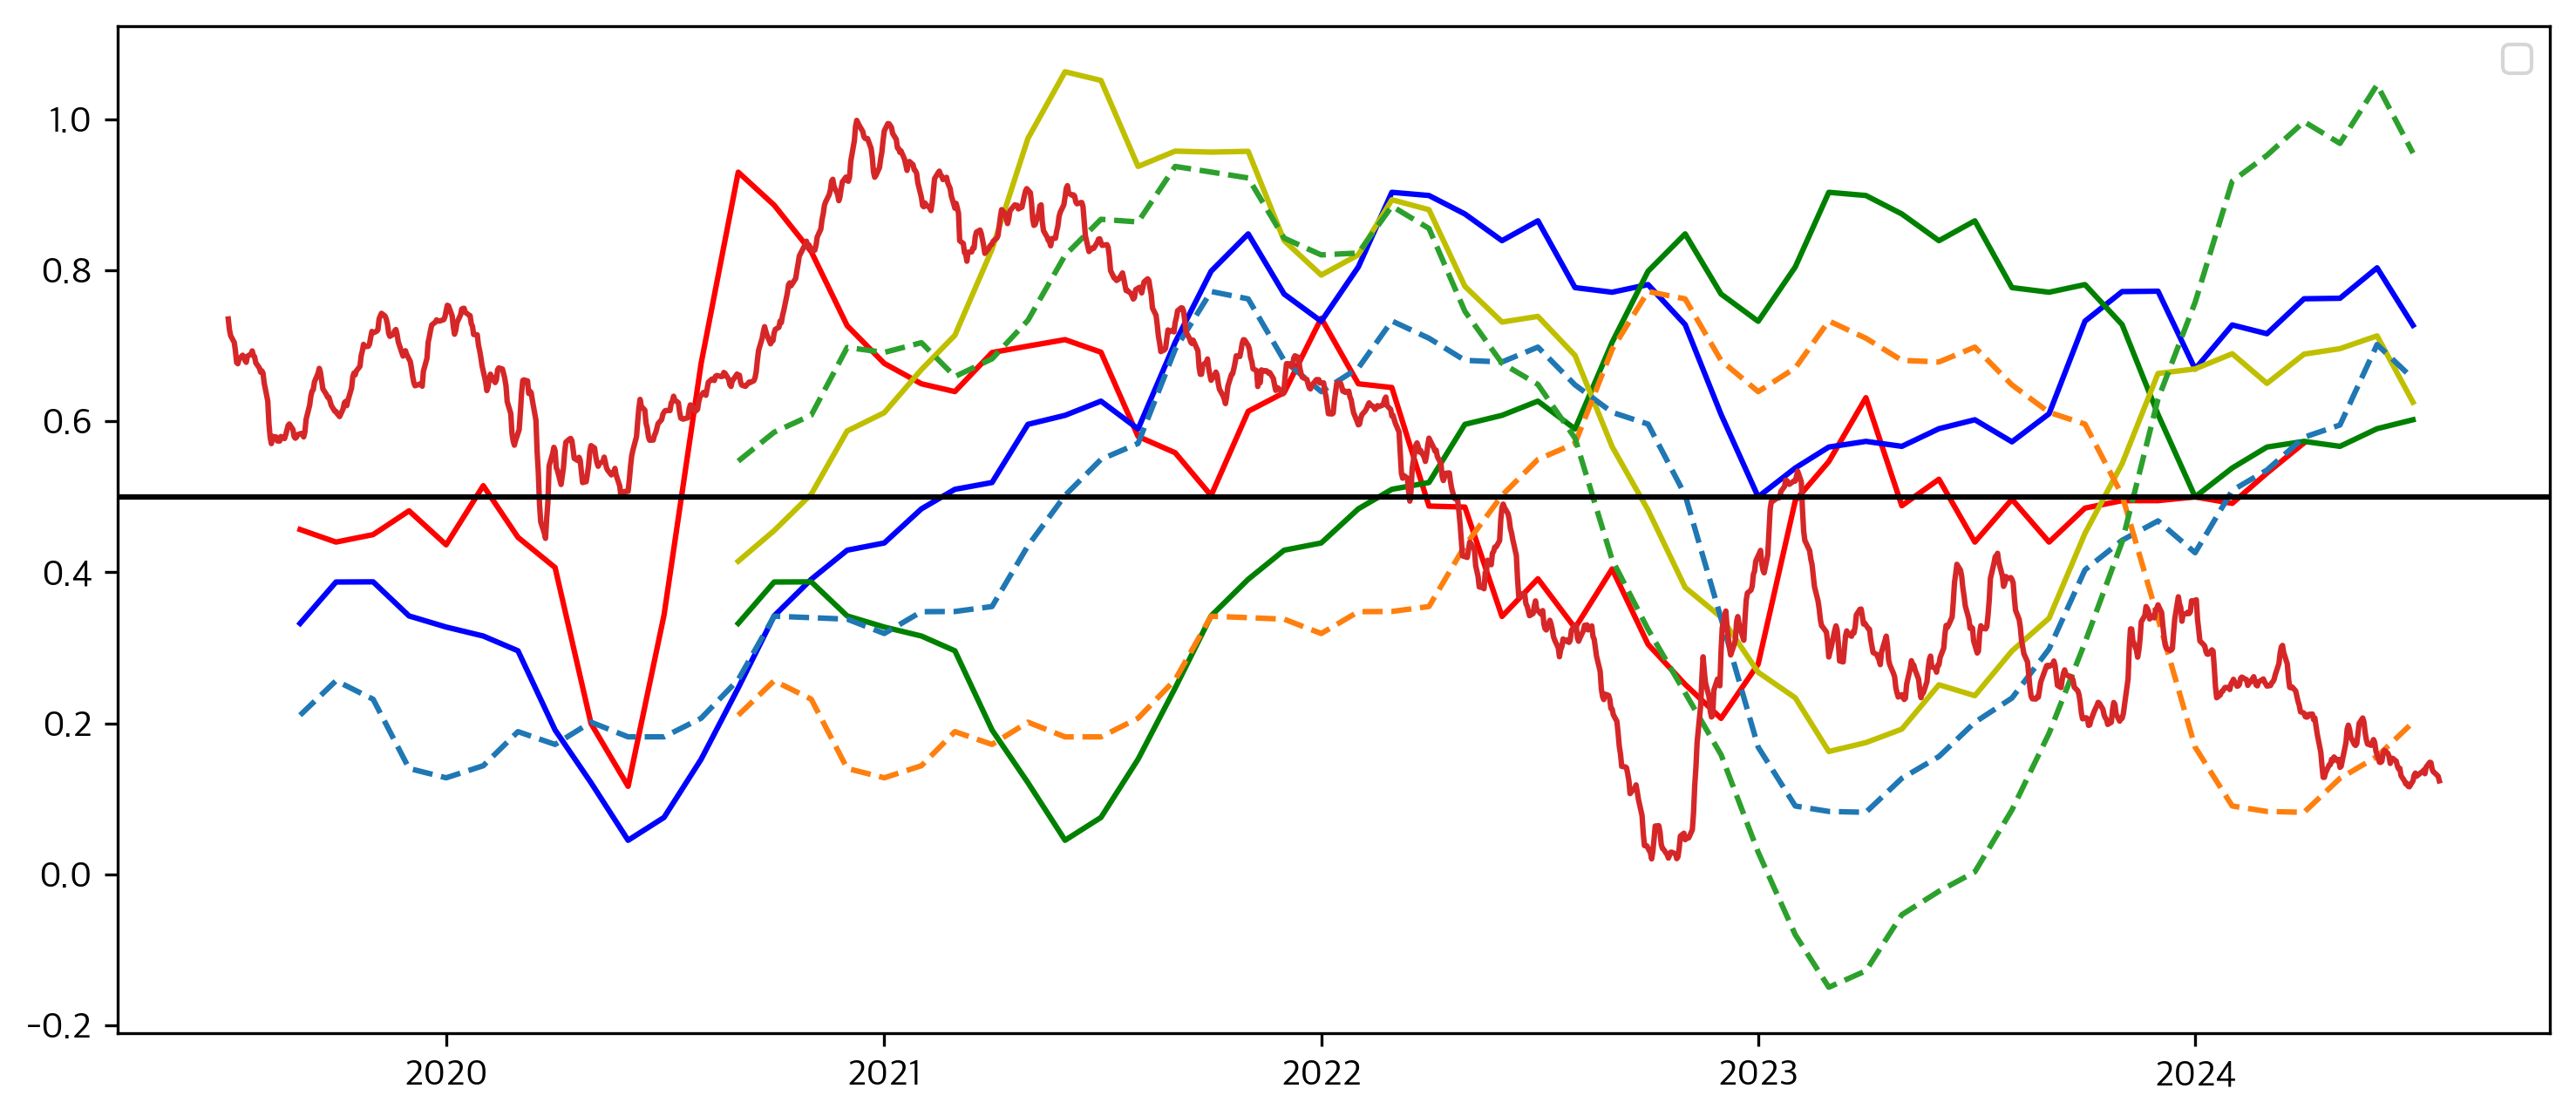

In [17]:
from matplotlib import pyplot as plt

plt.figure(figsize=(12, 5))
plt.plot(data2['ma'], color='r')
plt.plot(data['ma'], color='b')
plt.plot(data['ma-12'], color='g')
plt.plot(data['mayoy'], color='y')
plt.plot(semi['ma'], linestyle='dashed')
plt.plot(semi['ma-12'], linestyle='dashed')
plt.plot(semi['mayoy'], linestyle='dashed')
plt.plot(df['ma'])
plt.axhline(y=0.5, color='k', linestyle='-')
# plt.gca().spines[['top', 'right']].set_visible(False)
plt.legend()